AI Final Project
=============

[Dataset](https://www.kaggle.com/fedesoriano/heart-failure-prediction?select=heart.csv) from Kaggle

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

import lightgbm as lgb

In [2]:
RANDON_SEED = 42
TEST_SIZE = 0.2

# Exploratory Data Analysis
-------------

## Data Features

We can separate data features into numeric features, categorical features and the target for our task

### Numeric Features :

* Age: age of the patient [years]
* RestingBP: resting blood pressure [mm Hg]
* Cholesterol: serum cholesterol [mm/dl]
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
* Oldpeak: oldpeak = ST [Numeric value measured in depression]

### Categorical Features :


* Sex: sex of the patient [M: Male, F: Female]
* ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
* ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

### Target :

* HeartDisease: output class [1: heart disease, 0: Normal]


## Dataset

In [3]:
df = pd.read_csv("Dataset/heart.csv")

### Missing Values

In [4]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [5]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


First, let's take a glimpse of the dataset. It shows that there is no null value in the dataset.

However, we find that the minimum values of `RestingBP` and `Cholesterol` are 0, which is not normal.

We assume that they are missing the values filled with 0s incorrectly.



In [6]:
df[df['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


There is only 1 row missing value at `RestingBP`. We can simply remove this row.

In [7]:
df = df[df['RestingBP'] > 0]

In [8]:
df[df['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


In [9]:
df['Cholesterol'] = df['Cholesterol'].replace({0: np.nan})

It seems that there are so many missing values at `Cholesterol`. We replace 0s with `NaN` by now, will deal with them later.

### Duplicated Data

In [10]:
df[df.duplicated()]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


There is no duplicated data.

In [11]:
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'] # Numeric 
cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope'] # Categorical 
tar_col = ['HeartDisease'] # Target

## Categorical Features Encoding 
For further analysis, we want to encode the categorical features.
 
Before encoding, we need to separate categorical features into nominal and ordinal features.

Nominal variable comprises a finite set of discrete values with no relationship between values.

Ordinal variable comprises a finite set of discrete values with a ranked ordering between values.

### Nominal Features :
+ Sex
+ ExerciseAngina
### Ordinal Features :
+ ChestPainType
+ FastingBS
+ RestingECG
+ ST_Slope

In [12]:
nom_cols = ['Sex', 'ExerciseAngina']
ord_cols = ['ChestPainType', 'FastingBS', 'RestingECG', 'ST_Slope']
df_EDA = df.copy()

Nominal features in this dataset are both binary, so we can simply assign 0 and 1.

In [13]:
# Encode nominal features
df_EDA['Sex'] = df_EDA['Sex'].replace({'M':0, 'F':1})
df_EDA['ExerciseAngina'] = df_EDA['ExerciseAngina'].replace({'Y':1, 'N':0})
df_EDA[nom_cols].head()

,Sex,ExerciseAngina
0,0,0
1,1,0
2,0,0
3,1,1
4,0,0


Fortunately, ordinal features are introduced in sequence of order. We assign values according to the imformation given above

In [14]:
# Encode ordinal features
df_EDA['ChestPainType'] = df_EDA['ChestPainType'].replace({'TA': 3, 'ATA': 2, 'NAP': 1, 'ASY': 0})
df_EDA['RestingECG'] = df_EDA['RestingECG'].replace({'Normal':0, 'ST':1, 'LVH':2})
df_EDA['ST_Slope'] = df_EDA['ST_Slope'].replace({'Down': 0, 'Flat': 1, 'Up':2})
df_EDA[ord_cols].head()

,ChestPainType,FastingBS,RestingECG,ST_Slope
0,2,0,0,2
1,1,0,0,1
2,2,0,1,2
3,0,0,0,1
4,1,0,0,2


In [15]:
df_EDA.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,0,2,140,289.0,0,0,172,0,0.0,2,0
1,49,1,1,160,180.0,0,0,156,0,1.0,1,1
2,37,0,2,130,283.0,0,1,98,0,0.0,2,0
3,48,1,0,138,214.0,0,0,108,1,1.5,1,1
4,54,0,1,150,195.0,0,0,122,0,0.0,2,0


## Relation Observation 
After encoding, now we can show the relation between each feature with respect to the target.

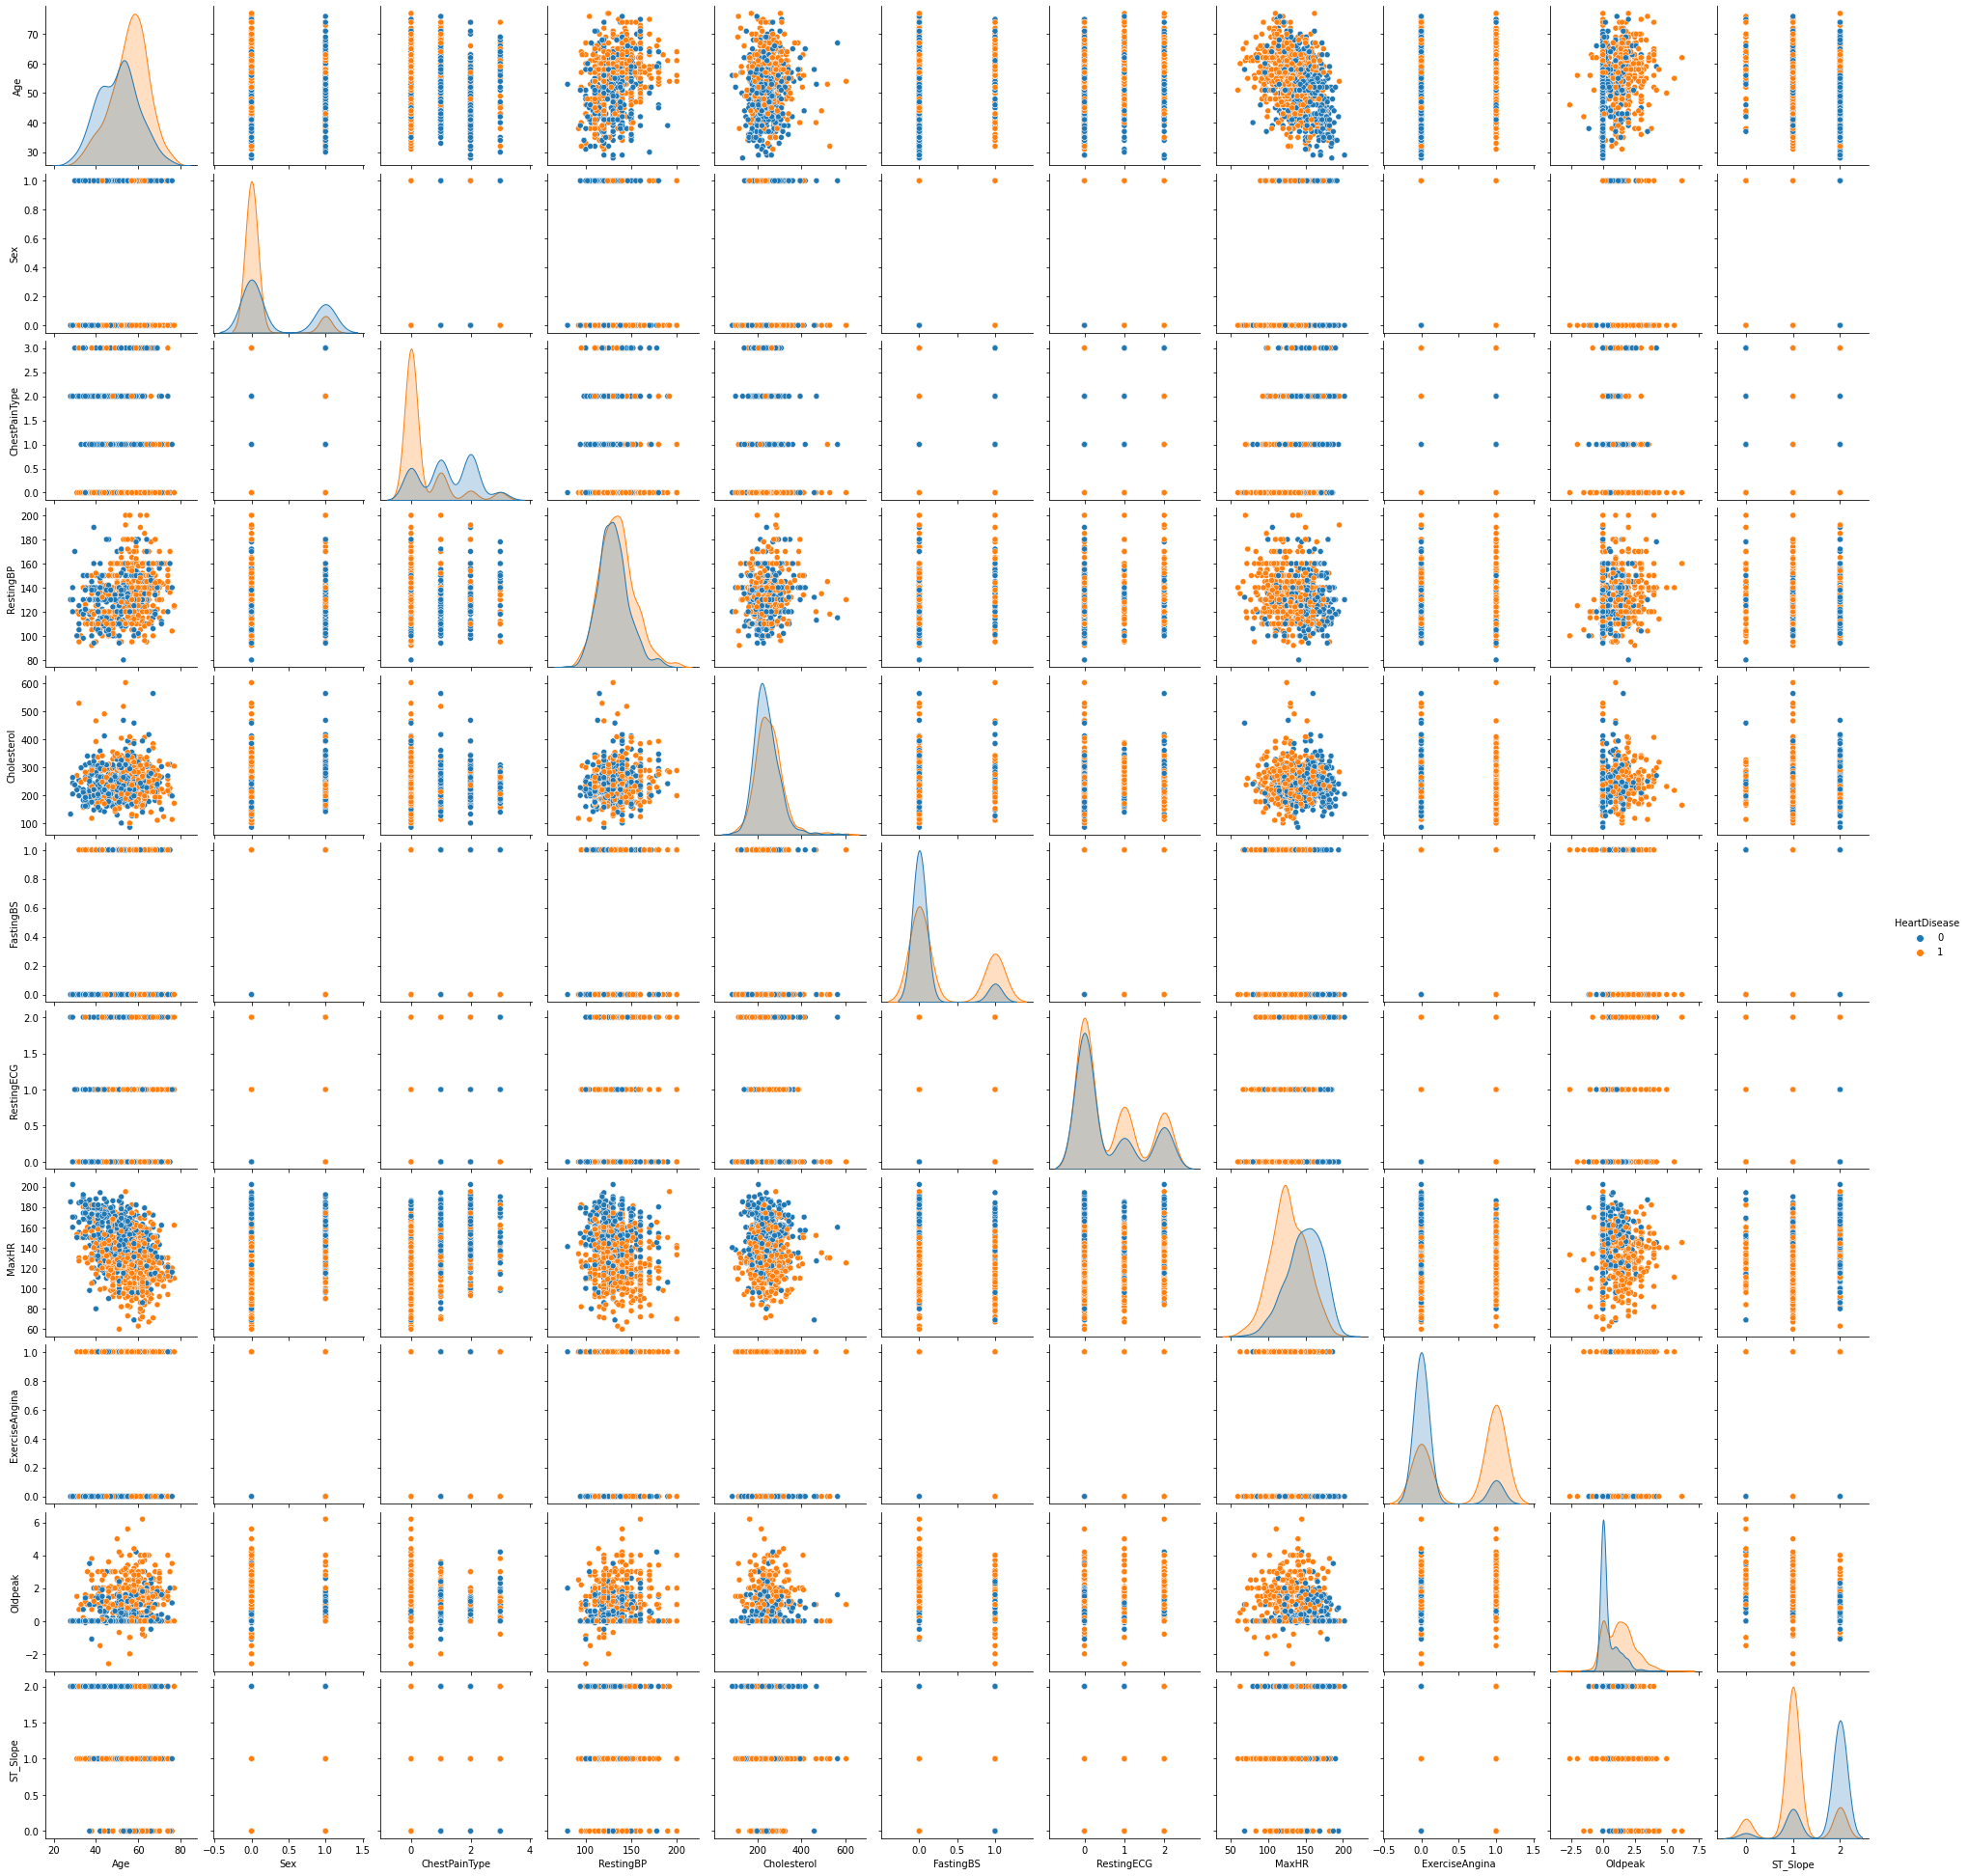

In [16]:
sns.pairplot(df_EDA, hue='HeartDisease')

Now we want to see the correlation between each numerical features

<AxesSubplot:>

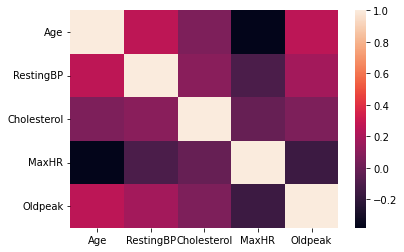

In [17]:
sns.heatmap(df_EDA[num_cols].corr())

As shown above, the correlation between each features are not high, so we don't have to worry about multicollinearity.

In [18]:
def num_plot(df, col):
    fig = px.histogram(df, x=col, color="HeartDisease",
                       marginal="box")
    fig.update_layout(height=400, width=500, showlegend=True)
    fig.update_traces(marker_line_width=1,marker_line_color="black")
    fig.show()

More detail about numerical features are shown below :

In [19]:
for col in num_cols:
    num_plot(df_EDA, col)

# Preprocessing
-------------

## Encoding Categorical Features
We encode the categorical features same as we did in EDA.

In [20]:
# Encode nominal features
df['Sex'] = df['Sex'].replace({'M':0, 'F':1})
df['ExerciseAngina'] = df['ExerciseAngina'].replace({'Y':1, 'N':0})
# Encode ordinal features
df['ChestPainType'] = df['ChestPainType'].replace({'TA': 3, 'ATA': 2, 'NAP': 1, 'ASY': 0})
df['RestingECG'] = df['RestingECG'].replace({'Normal':0, 'ST':1, 'LVH':2})
df['ST_Slope'] = df['ST_Slope'].replace({'Down': 0, 'Flat': 1, 'Up':2})
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,0,2,140,289.0,0,0,172,0,0.0,2,0
1,49,1,1,160,180.0,0,0,156,0,1.0,1,1
2,37,0,2,130,283.0,0,1,98,0,0.0,2,0
3,48,1,0,138,214.0,0,0,108,1,1.5,1,1
4,54,0,1,150,195.0,0,0,122,0,0.0,2,0


## Splitting Data
First of all, we need to split our dataset before further preprocessing.


In [21]:
X, y = df.drop(['HeartDisease'], axis = 1), df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDON_SEED, test_size = TEST_SIZE)

In [22]:
print(f'X_train size: {X_train.shape}\nX_test size: {X_test.shape}\ny_train size: {y_train.shape}\ny_test size: {y_test.shape}\n')

X_train size: (733, 11)
X_test size: (184, 11)
y_train size: (733,)
y_test size: (184,)



## Missing Data Imputation
After splitting, we can now study how to imput missing values of `Cholesterol`.

We perform the imputation only on the training set to avoid any data leakage.

Here we choose `KNNImputer` as our imputer. 

It is an imputation for completing missing values using k-Nearest Neighbors.

In [23]:
import numpy as np
import os
import pickle
imputer = KNNImputer()
X_train = imputer.fit_transform(X_train)
print(f'Null values in X_train: {np.isnan(X_train).sum()}')

# save the knn imputer model as pickle file
with open(os.path.join('Model','knnImputer.pkl'), 'wb+') as knnPickle:
    pickle.dump(imputer, knnPickle)

Null values in X_train: 0


Then we perform the transformation on the testing set as well.

In [24]:
X_test = imputer.transform(X_test)
print(f'Null values in X_test: {np.isnan(X_test).sum()}')

Null values in X_test: 0


## Feature Scaling

Standard mean/std scaler and min-max normalization are two common methods for feature scaling. 

However, there is a new technique called Gauss rank transformation.

It is believed that Gauss rank transformation has better performance in deep neural networks training.

Therefore, we want to give it a try.

In [46]:
from scipy.special import erfinv

def rank_gauss(x):    
    rank = x.argsort().argsort() # compute the rank
    rank = (rank/rank.max()-0.5)*2 # scale to (-1, 1)
    epsilon = 1e-6
    rank = np.clip(rank, -1+epsilon, 1-epsilon)
    rank = erfinv(rank) # map to gaussian
    return rank

### Gauss Rank Transformation on Numeric Features

In [49]:
train_df = pd.DataFrame(X_train, columns=df.drop(['HeartDisease'], axis=1).columns)
scaled_train_df = train_df.copy()

In [50]:
for col in num_cols:
    scaled_train_df[col] = rank_gauss(train_df[col].values)

### MinMax Scaler on Categorical Features
Since nominal features are encoded in 0 and 1, there is no need for further operation.

We only need to scale ordinal features.

In [56]:
from sklearn.preprocessing import minmax_scale
for col in ord_cols:
    scaled_train_df[col] = minmax_scale(train_df[col])

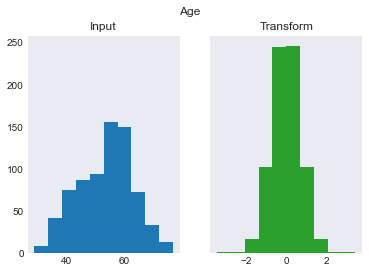

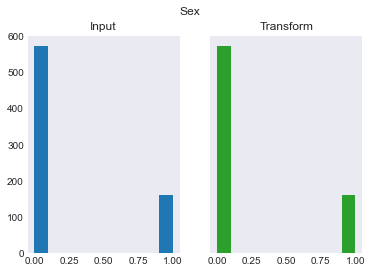

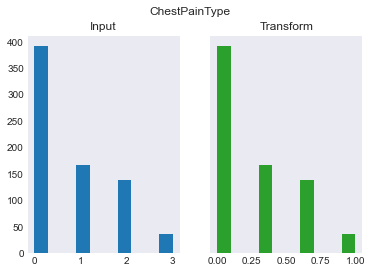

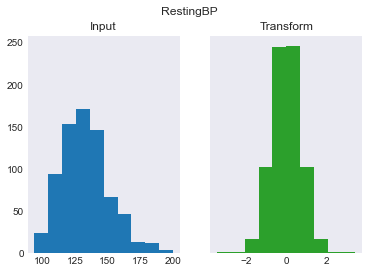

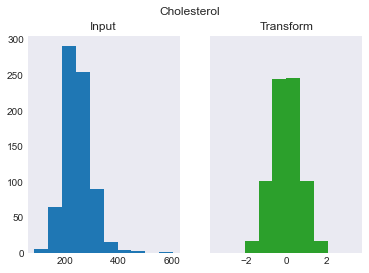

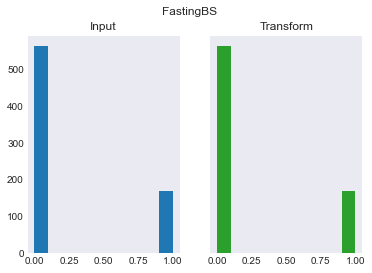

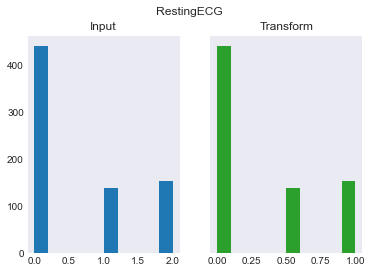

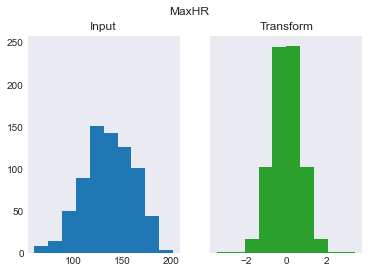

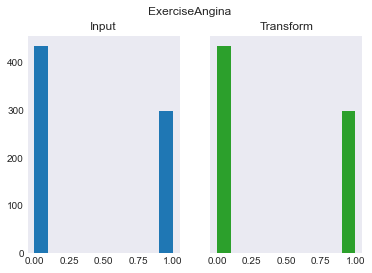

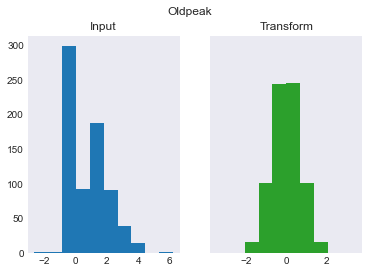

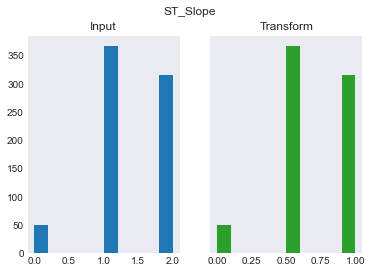

In [63]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
for col in train_df.columns:
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
    fig.suptitle(col)
    ax1.hist(train_df[col], color='C0')
    ax1.set_title('Input')
    ax2.hist(scaled_train_df[col], color='C2')
    ax2.set_title('Transform')
    

## Feature Selection

# Model Building
---------------------

# Model Training
-----------------

# Model Testing 
-----------------

# Comparison Among Different Methods
------------